# Практическое домашнее задание 1. Поиск похожих изображений с помощью SVD.

Версия от 19.02.2024.
Карпова Анна 

В этой задаче мы познакомимся с одним из возможных приложений сингулярного разложения — поиск "хорошего" базиса (eigenfaces) в наборе изображений и использования его для поиска похожих изображений.

**Замечание:** пользоваться циклами по изображениям **запрещено**, если это явно не прописано в условии.

Для этого сначала загрузим набор изображений, на котором будем обучаться. Это набор фотографий лиц, взятый с [сайта](http://vis-www.cs.umass.edu/lfw/) проекта "Labeled faces in the wild". Скачайте лица людей с именами, начинающимися на "А" и положите в папку `data/` в рабочей директории ноутбука.

Импортируем необходимые библиотеки и загрузим картинки в виде numpy-массивов. 

In [1]:
import matplotlib.pyplot as plt
import PIL
import tarfile
import os
import numpy as np


def load_images(targz, size):
    images = {}
    tar = tarfile.open(targz, "r:gz")
    for tarinfo in tar:
        if tarinfo.isreg():
            file = tar.extractfile(tarinfo)
            image = PIL.Image.open(file)
            image = image.convert("L")
            image = image.resize(size, PIL.Image.LANCZOS)
            image = np.asarray(image, dtype=np.double)
            image /= np.linalg.norm(image)
            parts = os.path.normpath(tarinfo.name).split(os.path.sep)
            images.setdefault(parts[-2], []).append(image)
    return images

In [2]:
size = 256
images = load_images("data/lfw-a.tgz", (size, size))

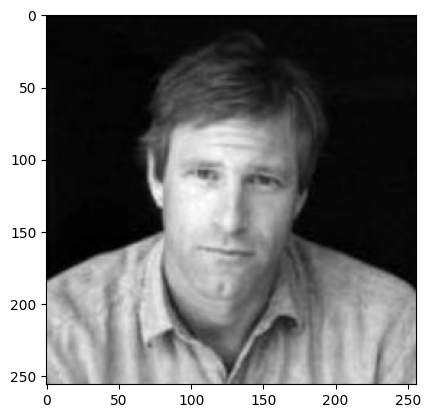

In [3]:
_ = plt.imshow(images["Aaron_Eckhart"][0], cmap="gray")

Сразу отложим одно изображение для последующего поиска.



In [4]:
test_image = images["Alejandro_Toledo"][10]
del images["Alejandro_Toledo"][10]

### a. Применение базового алгоритма SVD (35 баллов)

1. **(4 балла)** С помощью функции ```np.reshape(...)``` получите из словаря `images` массив ```M``` размера ```(size * size, nframes)```, каждым столбцом которого является изображение размера ```(size, size)```, представленное в виде вектора длины ```size**2``` (используйте такое значение параметра `order`, чтобы обходить картинки по столбцам).

*В этом пункте (и только в этом) можно использовать цикл по изображениям.*

In [5]:
cou = 0
for name in images:
    imgs = images[name]
    for image in imgs:
        cou += 1
        if cou == 1:
            M = np.reshape(image, (1, 256 * 256), "F")
        else:
            M = np.append(M, np.reshape(image, (1, 256 * 256), "F"), axis=0)
M = M.T

[[0.         0.00830756 0.00757426 ... 0.0039546  0.00665002 0.00521268]
 [0.         0.00851439 0.00757426 ... 0.00443761 0.00665002 0.00521268]
 [0.         0.00854886 0.00757426 ... 0.00476968 0.00665002 0.00521268]
 ...
 [0.00640797 0.00165462 0.0051493  ... 0.00172071 0.00404217 0.        ]
 [0.00670701 0.00148226 0.00517924 ... 0.00175089 0.0038857  0.        ]
 [0.00687789 0.00137885 0.00517924 ... 0.00178108 0.00375531 0.        ]]


In [6]:
nframes = len(M[0])
print(len(M), nframes)

65536 1053


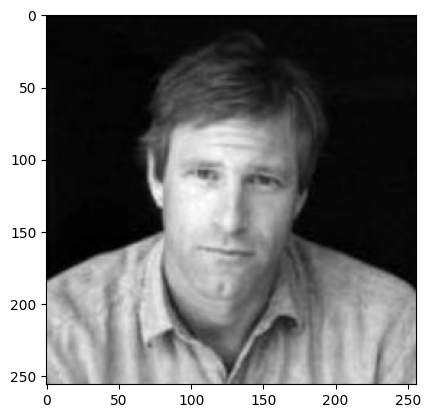

In [7]:
plt.imshow(M[:, 0].reshape((256, 256), order="F"), cmap="gray")

2. **(10 баллов)** Вычислите сингулярное разложение матрицы ```M``` с помощью ```np.linalg.svd``` и постройте график сингулярных чисел, отсортированных по убыванию. Шкала с сингулярными числами должна быть логарифмической. Например, для этого можно использовать функцию ```plt.semilogy```.
 
    **Замечание:** При построении графиков величин с отличающимися на порядки значениями полезно использовать логарифмическую шкалу. Чтобы убедиться в этом, попробуйте построить график не в логарифмической шкале; из него будет фактически невозможно понять характер убывания сингулярных чисел.

In [8]:
U, S, Vh = np.linalg.svd(M, full_matrices=False)

Построю графики с логарифмической шкалой и без нее для наглядности

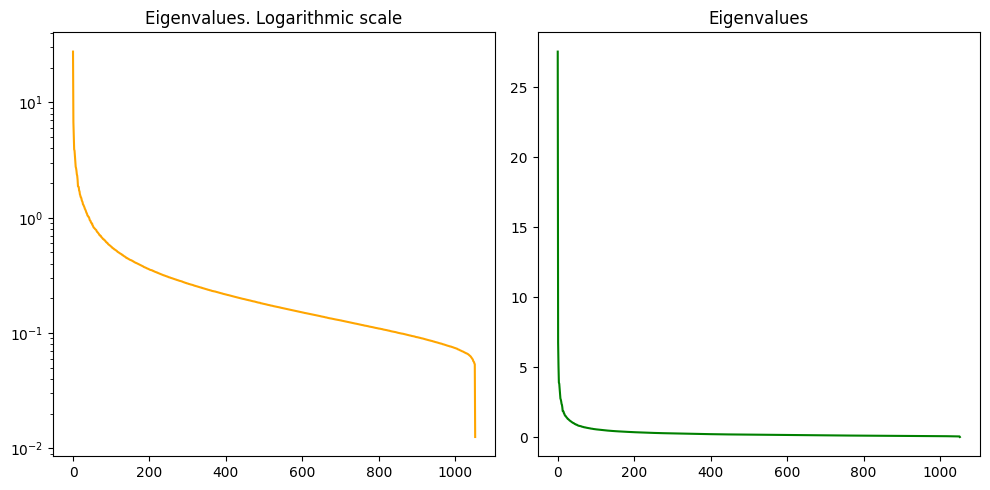

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.semilogy(S, color="orange")
plt.title("Eigenvalues. Logarithmic scale")

plt.subplot(1, 2, 2)
plt.plot(S, color="green")
plt.title("Eigenvalues")

plt.tight_layout()

 3. **(5 баллов)** Заполните пропуск в следующей функции, которая должна визуализировать вектор-столбцы нашей матрицы в виде таблицы. Затем с её помощью визуализируйте несколько первых сингулярных векторов. Опишите неформально, за что отвечают три старших сингулярных вектора.

In [10]:
def plot_as_images(mat, rows, cols):
    """
    Visualize images from the columns of mat in a table of shape (rows, cols).

    Input
        mat: numpy array of shape (size * size, rows * cols)
        rows: number of rows in the table
        cols: number of columns in the table
    """
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for i in range(rows):
        for j in range(cols):
            axes[i, j].imshow(
                mat[:, i * cols + j].reshape((256, 256), order="F"), cmap="gray"
            )
            axes[i, j].get_xaxis().set_visible(False)
            axes[i, j].get_yaxis().set_visible(False)

Визуализирую первые 5 столбцов и строк.

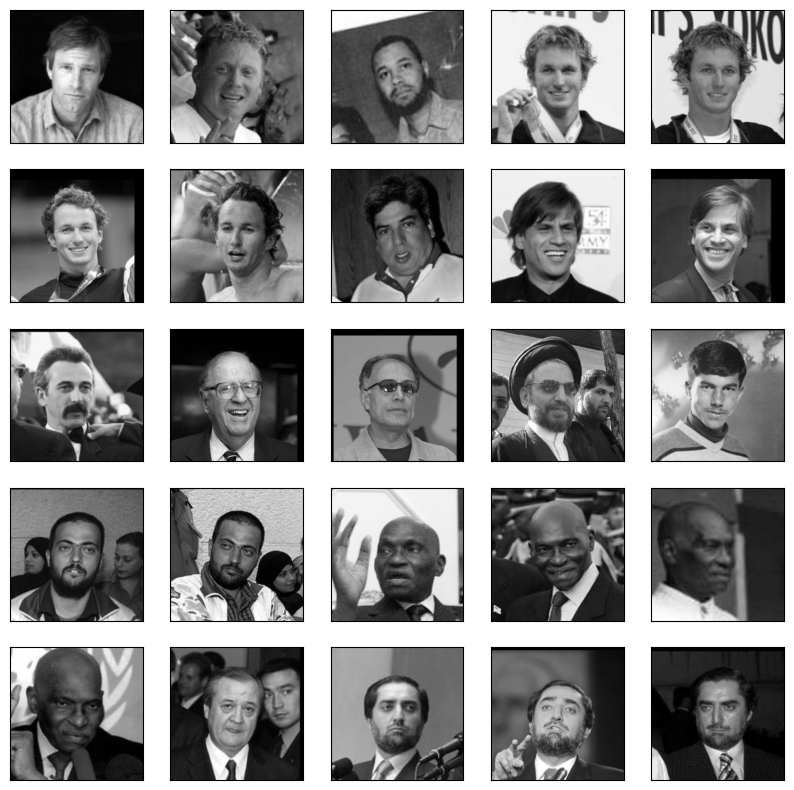

In [11]:
plot_as_images(M, 5, 5)

Визуализирую  первые 10 сингулярных векторов (крипово, если честно..)

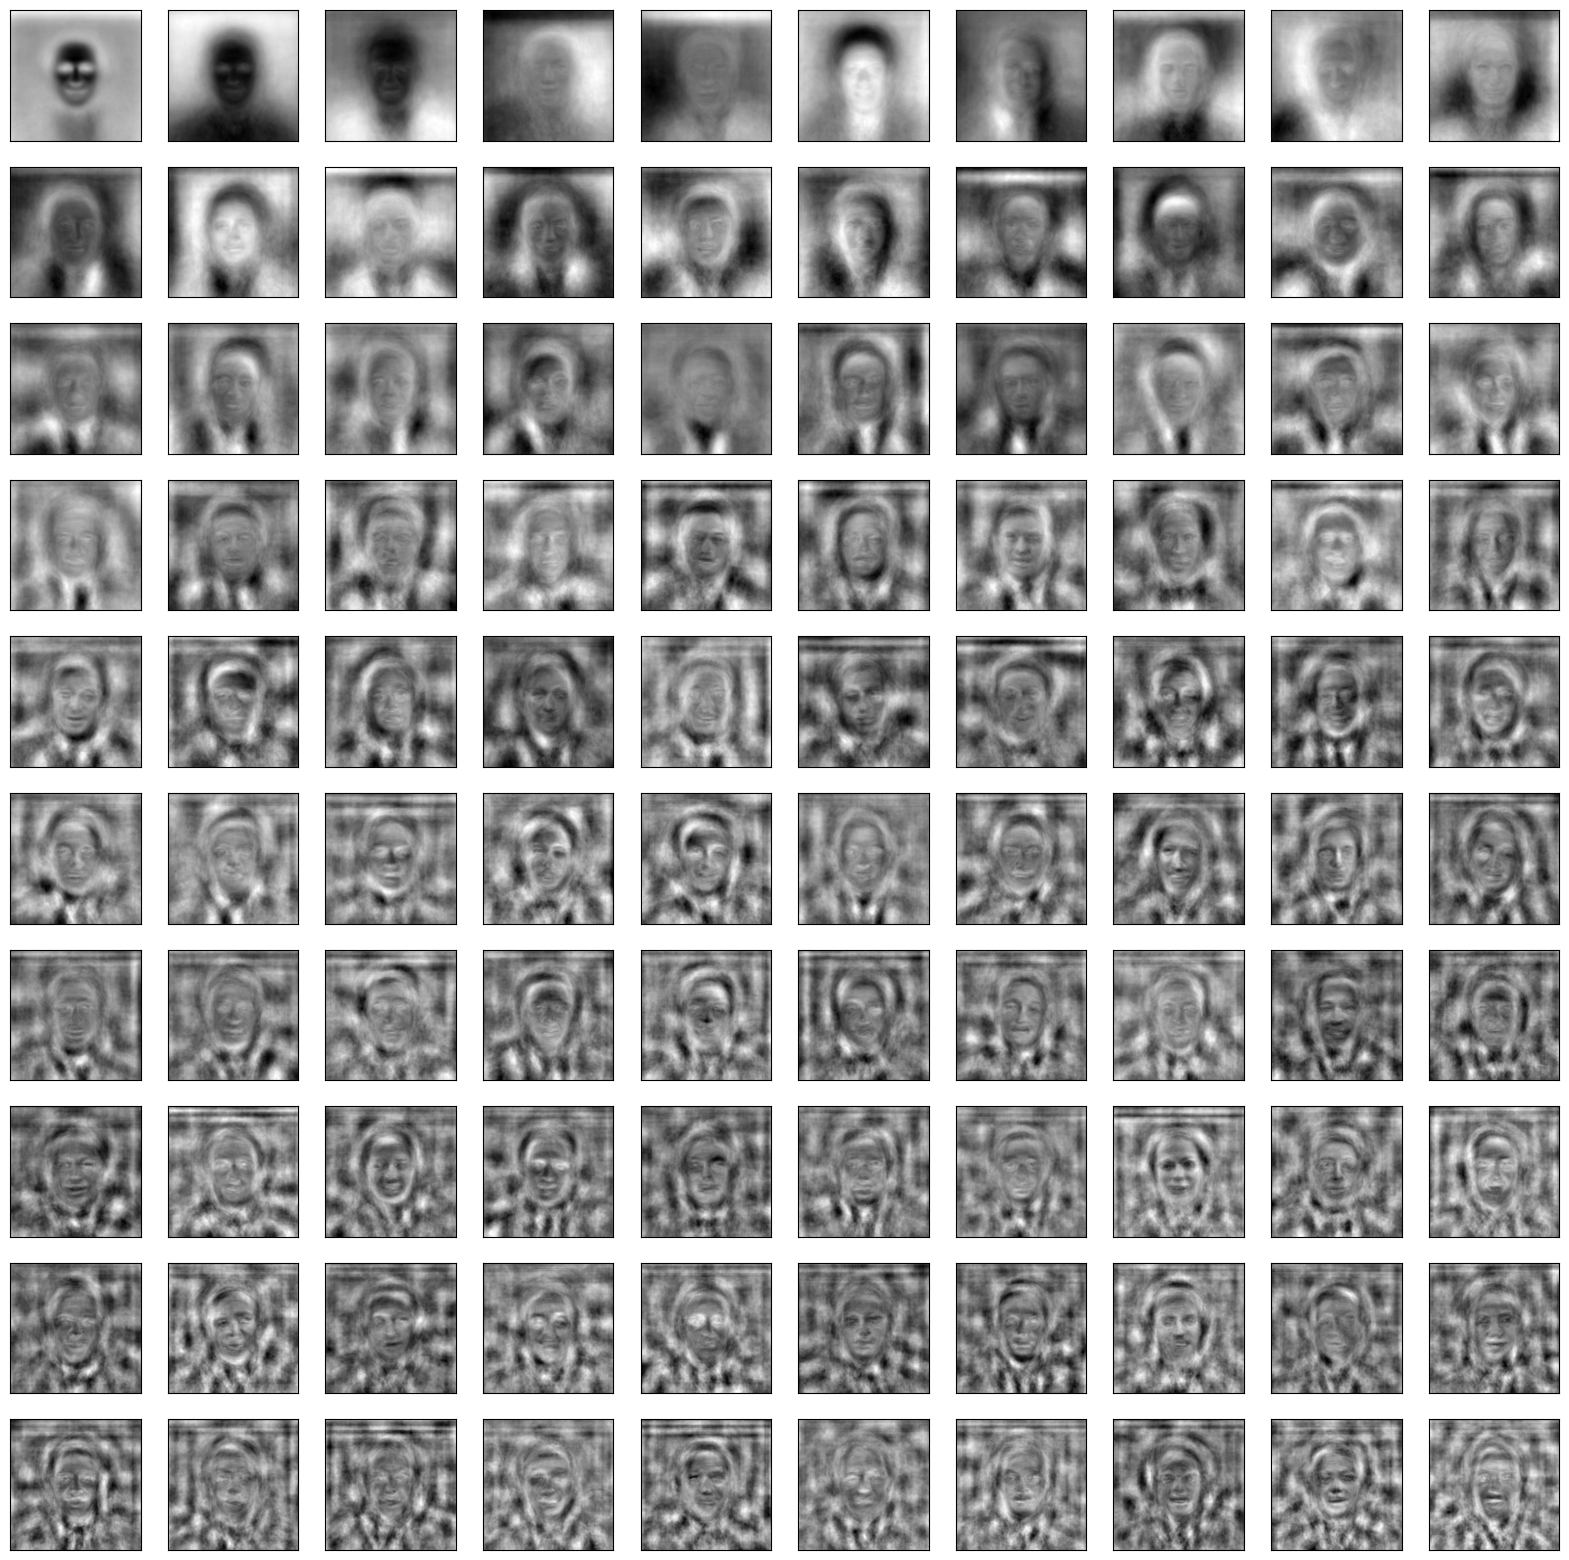

In [12]:
plot_as_images(U, 10, 10)

Смотря на картинки, можно сделать вывод, что первые три сингулярных векторов нужны, чтобы различать силуэты, очертания людей.
Это своебразный скелет, на котором строится изображение, как я понимаю

4. **(10 баллов)** Напишите функцию ```trunc_svd(M, r)```, которая вычисляет оптимальное приближение $M_{r}$ двумерного массива $M$ заданного ранга. Функция должна возвращать матрицы $U$ и $C$ такие, что столбцы матрицы $U$ составляют ортонормированный базис столбцов $M_{r}$, а $UC = M_{r}$. Также функция `trunc_svd` возвращает **относительную** точность приближения во Фробениусовой норме, т.е.
$$
    \frac{\|M - M_{r}\|_F}{\|M\|_F}.
$$
Для вычисления относительной точности используйте только полученные из сингулярного разложения сингулярные числа.

In [13]:
def trunc_svd(M, r):
    """
    Input
        M: original 2D numpy array
        r: rank value for truncation

    Output
        U: orthonormal basis of columns of Mr
        C: coefficients in equality Mr = UC
        rel_eps: relative error of rank-r approximation Mr
    """

    U, S, Vh = np.linalg.svd(M, full_matrices=False)
    second = (np.diag(S[:r])).dot(Vh[:r, :])
    third = np.linalg.norm(S[r:]) / np.linalg.norm(S)
    return U[:, :r], second, third

    raise NotImplementedError()

На всякий выведу

In [14]:
U, C, eps = trunc_svd(M, 2)
print(U, C, eps, sep="\n ----- \n")

[[-0.00213203  0.00410396]
 [-0.00217243  0.00411608]
 [-0.00223041  0.00425366]
 ...
 [-0.00292574 -0.00232342]
 [-0.00292339 -0.00233912]
 [-0.00291796 -0.00233081]]
 ----- 
[[-0.76612011 -0.88613554 -0.9148982  ... -0.8928032  -0.86002608
  -0.90218121]
 [-0.48715178 -0.02803156  0.1054671  ...  0.04717154  0.13665931
   0.0982053 ]]
 ----- 
0.4849244119707688


5. **(6 баллов)** Проверим работу написанной функции. Для этого воспользуемся функцией, которая рисует исходное изображение, приближение некоторого ранга, а также первые `count` сингулярных векторов в разложении вместе с их коэффициентами. Заполните пропуски в ней с помощью метода `reshape`.

In [15]:
def plot_as_combination(M, U, C, count, indices):
    """
    Input
        M: original 2D numpy array
        U: orthonormal basis of columns of Mr
        C: coefficients in equality Mr = UC
        count: desired number of images of singular vectors
        indices: indices of columns of M which are visualized
    """

    fig, all_axes = plt.subplots(
        len(indices), count + 2, figsize=(count * 2, len(indices) * 2)
    )

    for i, index in enumerate(indices):
        axes = all_axes[i, :]

        axes[0].imshow(
            M[:, index].reshape((size, size), order="F"), cmap="gray"
        )  # Original image
        axes[0].set_xlabel("Orig")

        appr = U @ C[:, index]
        axes[1].imshow(
            appr.reshape((size, size), order="F"), cmap="gray"
        )  # Approximation image
        axes[1].set_xlabel("Appr")

        for j in range(count):
            axes[2 + j].imshow(
                U[:, j].reshape((size, size), order="F"), cmap="gray"
            )  # i-th singular vector image
            axes[2 + j].set_xlabel("{:.7}".format(C[j, index]))

        for ax in axes:
            ax.set_xticks([])
            ax.get_yaxis().set_visible(False)

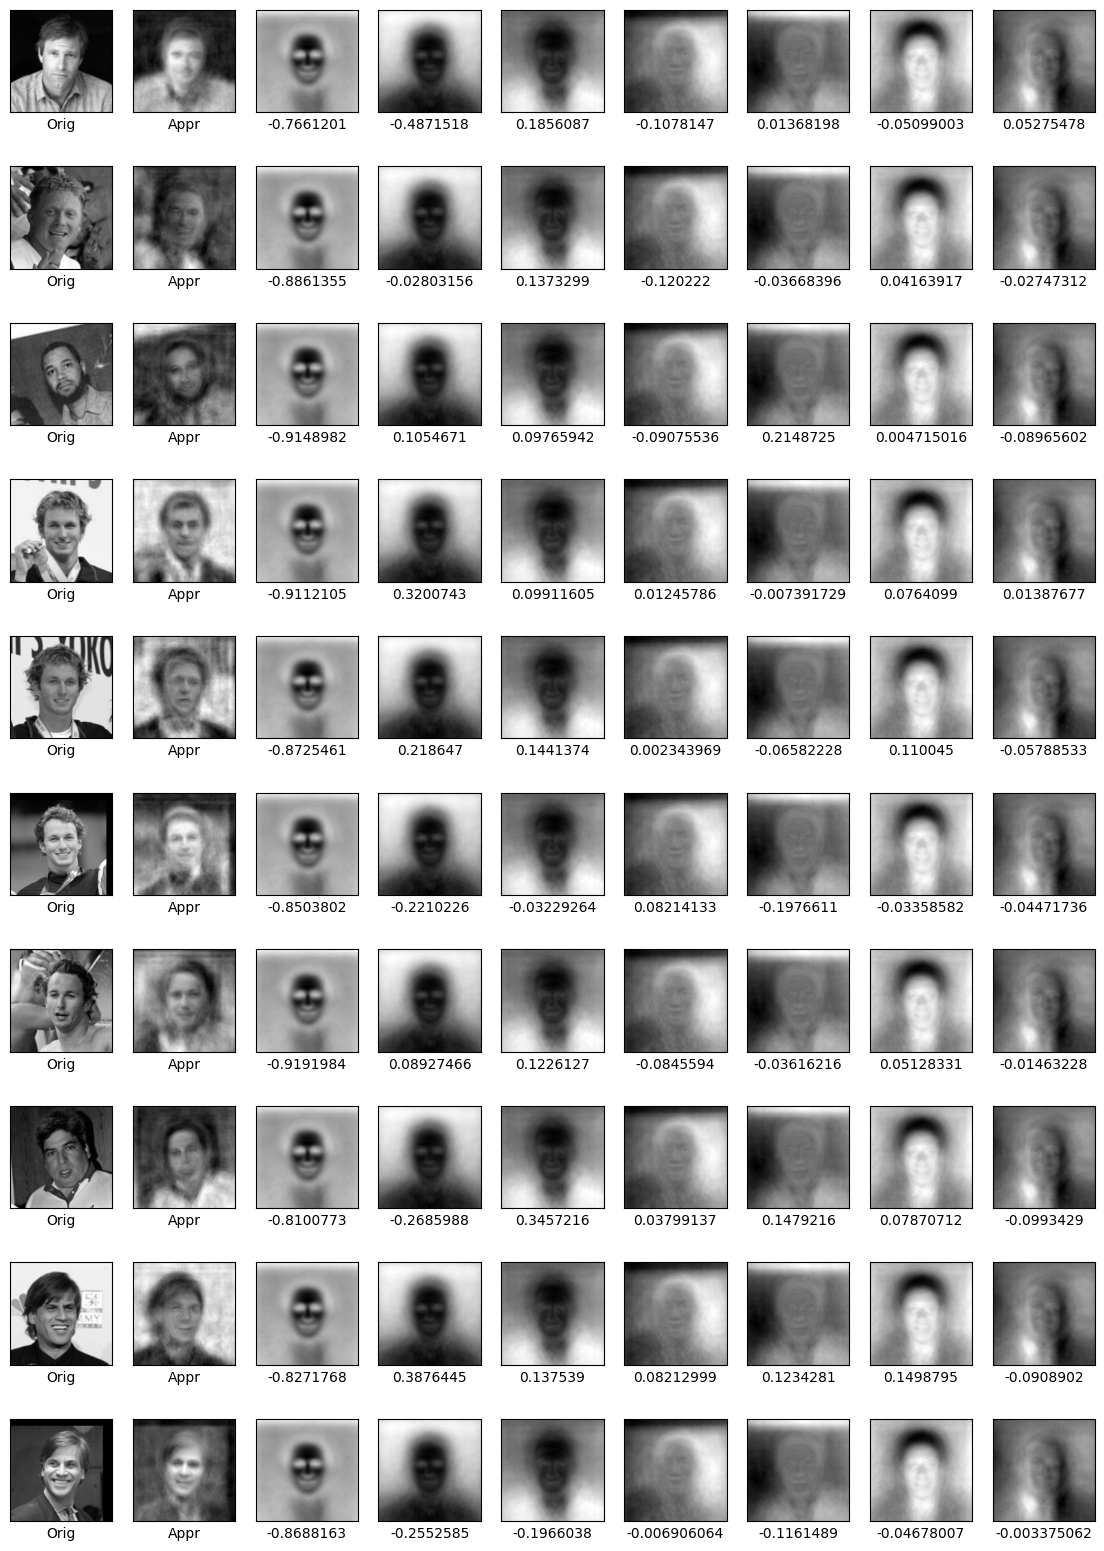

In [16]:
U, C, eps = trunc_svd(M, 100)
plot_as_combination(M, U, C, 7, range(10))

### b. Применение рандомизированного алгоритма SVD (35 баллов)

Использование функции ```np.linalg.svd``` является эффективным для относительно небольших массивов из-за быстрого (кубического) роста сложности алгоритма в зависимости от размера матрицы. Используем рандомизированный алгоритм из лекций для ускорения вычислений.

1. **(20 баллов)** Реализуйте рандомизированный алгоритм SVD из лекций, который аппроксимирует матрицу с заданным рангом $r$ (алгоритм запускается с ```r + p``` случайных векторов, после чего ранг обрезается до ```r``` с наименьшей ошибкой). Убедитесь, что вы **не вычисляете** в явном виде матрицу $QQ^*$.

In [17]:
def rand_svd(M, r, p=10):
    """
    Input
        M: 2D numpy array
        r: rank value for truncation
        p: number of extra random vectors to approximate range(M)

    Output
        Mr: 2D numpy array of rank r and of the same size as M
        rel_eps: relative error of rank-r approximation Mr
    """
    # ниже алгоритм с лекции
    Omega = np.random.randn(nframes, r + p)  # p - oversample
    Y = M.dot(Omega)
    Q, R = np.linalg.qr(Y)

    W, Sig, Vh = np.linalg.svd((Q.T).dot(M), full_matrices=False)
    new_M = Q.dot(W)[:, :r]
    new_M = (new_M).dot(np.diag(Sig[:r]))
    new_M = (new_M).dot(Vh[:r, :])
    return new_M, (np.linalg.norm(M - new_M) / np.linalg.norm(M))

    raise NotImplementedError()

На всякий случай выведу

In [18]:
rand_svd(M, 5)

(array([[ 0.00028718,  0.00205086,  0.00257522, ...,  0.00202231,
          0.00227083,  0.00294583],
        [ 0.00017904,  0.00192022,  0.00251049, ...,  0.00187584,
          0.00207029,  0.00263803],
        [-0.00014787,  0.00180252,  0.00255642, ...,  0.00188215,
          0.00203958,  0.0024508 ],
        ...,
        [ 0.00279207,  0.00281704,  0.00274956, ...,  0.00203149,
          0.00179629,  0.00159139],
        [ 0.00271256,  0.00275656,  0.0027321 , ...,  0.00204703,
          0.00179912,  0.00158411],
        [ 0.00272623,  0.0026988 ,  0.00260254, ...,  0.00201663,
          0.00178956,  0.00156548]]),
 0.47123114147283285)

2. **(10 баллов)** Постройте график функции
$$
\frac{||M_{rand}(p) - M||_F}{||M_{SVD} - M||_F} - 1
$$
в зависимости от $p$ для $r=50$. По $p$ выберите сетку $[0, 100]$ с шагом 5.
Так как $M_{rand}(p)$ получено с помощью рандомизированного алгоритма, усредните Ваш результат, запустив алгоритм 10 раз.
При построении графика используйте логарифмическую шкалу.

Выведу p, чтобы было интереснее наблюдать за процессом

[  0   5  10  15  20  25  30  35  40  45  50  55  60  65  70  75  80  85
  90  95 100]
p = 0
p = 5
p = 10
p = 15
p = 20
p = 25
p = 30
p = 35
p = 40
p = 45
p = 50
p = 55
p = 60
p = 65
p = 70
p = 75
p = 80
p = 85
p = 90
p = 95
p = 100


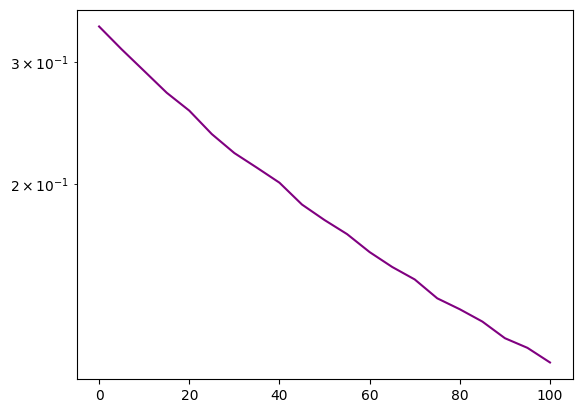

In [19]:
r = 50
p_grid = np.arange(0, 101, 5)
print(p_grid)
result = np.ndarray(21)  # т.к в промежутке от 0 до 100 с шагом 5 получается 21 число

svd_trunc = trunc_svd(M, r)
i = 0
for p in p_grid:
    print(f"p = {p}")
    tmp = []
    for j in range(10):
        tmp.append(rand_svd(M, r, p)[1])
    svd_rand = np.array([tmp]).mean()
    result[i] = svd_rand / svd_trunc[2] - 1
    i += 1

plt.semilogy(p_grid, result, color="purple")

3. **(5 баллов)** С помощью ```%timeit``` сравните время расчета для ```trunc_svd``` и ```rand_svd``` для ранга $r = 50$. Во сколько раз рандомизированный алгоритм быстрее ```np.linalg.svd``` для матрицы ```M```?

Время на trunc_svd

In [20]:
%timeit trunc_svd(M, 50)

8.13 s ± 498 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Время на rand_svd

In [21]:
%timeit rand_svd(M, 50)

1.45 s ± 201 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Время на подсчет SVD с помощью np.linalg.svd

In [22]:
%timeit np.linalg.svd(M, full_matrices=False)

9.76 s ± 1.67 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


Выходит, что *рандомизированный SVD*  работает примерно в 8 раз быстрее, чем *np.linalg.svd*

### c. Поиск нового изображения (30 баллов)

Представьте, что нам выдали новое изображение `new`, которого в нашей базе нет. Чтобы найти в базе похожие, можно посчитать норму разности с каждым имеющимся изображением. Для проверки напишем вспомогательную функцию, которая будет показывать подписанные картинки.

In [23]:
def show_images(M, indices, names):
    fig, axes = plt.subplots(1, len(indices), figsize=(len(indices) * 3, 3))
    for ax, index in zip(axes, indices):
        ax.imshow(M[:, index].reshape((size, size), order="F"), cmap="gray")
        ax.get_xaxis().set_ticks([])
        ax.set_xlabel(names[index])
        ax.get_yaxis().set_visible(False)

   1. **(10 баллов)** Напишите функцию, находящее ближайшее во фробениусовой норме изображение.

In [44]:
def get_closest_naive(M, new_v, count):
    """
    Input
        M: matrix of vectorized images
        new_v: new image as a vector of shape (size**2,)
        count: desired number of closest images

    Output
        indices: list of count indices of closest images
    """
    new_M = M - (new_v[:, None])
    norms = np.linalg.norm(new_M, axis=0)
    return np.argsort(norms)[:count]

Проверим её на тестовом изображении. Как минимум один Алехандро Толедо должен найтись.

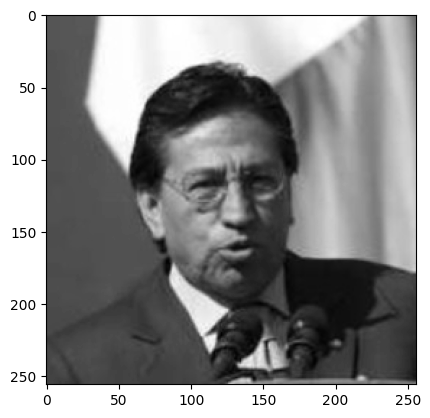

In [45]:
new = test_image
_ = plt.imshow(new, cmap="gray")

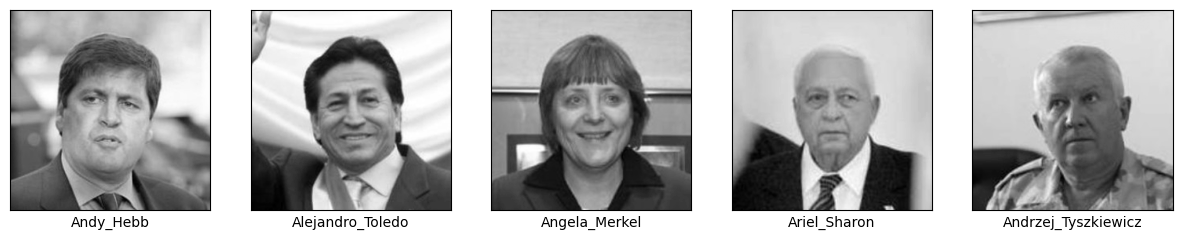

In [46]:
new_v = new.ravel(order="F")
names = sum(map(lambda item: [item[0]] * len(item[1]), images.items()), [])
show_images(M, get_closest_naive(M, new_v, 5), names)

Помимо того, что такой подход может оказаться неприемлемым с точки зрения производительности, он также не устойчив:  например, изменение освещения или фона может очень сильно изменить норму разности.

   2. **(20 баллов)** Применим подход, использующий SVD. Именно, спроецируем новое изображение на пространство, задаваемое ортонормированным базисом $U$, и будем сравнивать норму разности проекций. Причём для устойчивости к изменению освещения не будем учитывать первую компоненту в разложении по столбцам матрицы $U$. Напишите функцию `get_closest_proj`, которая возвращает индексы `count` изображений по описанному алгоритму.

In [47]:
def get_closest_proj(U, C, new_v, count):
    """
    Input
        U: orthonormal basis of columns of Mr
        C: coefficients in equality Mr = UC
        new_v: new image as a vector of shape (size**2,)
        count: desired number of closest images

    Output
        indices: list (of len `count`) of indices of closest images
    """
    U_copy = U[:, 1:].copy()
    C_copy = C[1:, :].copy()
    # new_v_c = new_v.reshape((len(new_v_c), 1), order='F')
    pr_v = U_copy @ (U_copy.T @ new_v)  # проекция new_v на пр-ство, задаваемое U
    result = U_copy.dot(C_copy) - pr_v[:, None]
    norm = np.linalg.norm(result, axis=0)
    return np.argsort(norm)[:count]

Проверим подход с SVD  том же тестовом изображении. Правильно реализованный метод должен найти как минимум два изображения Алехандро.

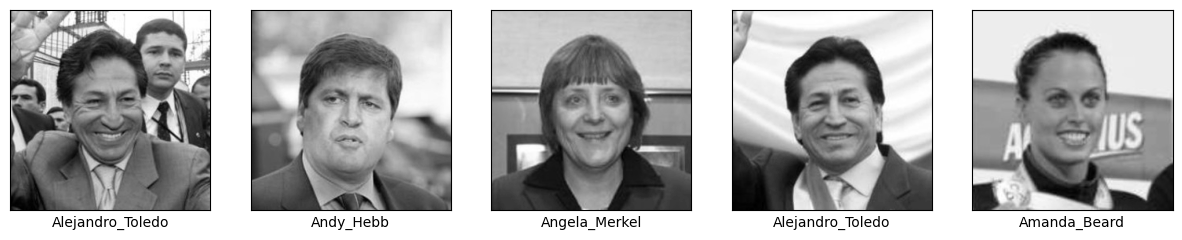

In [48]:
show_images(M, get_closest_proj(U, C, new_v, 5), names)

### c. Бонус

В бонусной части мы познакомимся с более продвинутыми рандомизированными алгоритмами поиска сингулярного разложения. Условие заданий базируется на статье 

Halko, Nathan, Per-Gunnar Martinsson, and Joel A. Tropp. "Finding structure with randomness: Probabilistic algorithms for constructing approximate matrix decompositions." SIAM review 53.2 (2011): 217-288.

**Ссылка на статью**: http://users.cms.caltech.edu/~jtropp/papers/HMT11-Finding-Structure-SIREV.pdf

1. **(50 б. баллов)** Докажите, что в точной арифметике результат, полученный при использовании Алгоритма 4.3 и 4.4 из статьи, указанной выше, совпадают. Все теоретические выкладки приведите в текущем файле с использованием Markdown или прикрепите качественное изображение рукописного текста.

2. **(50 б. баллов)** Реализуйте Алгоритм 4.4 и используйте его для построения приближенного сингулярного разложения матрицы A на матрице из этой ДЗ. Зафиксируйте ранги $r=5, 20, 50$. Для каждого из этих значений на одном рисунке постройте график зависимости нормы (на выбор) разности полученного приближения и оптимального приближения (в выбранной норме) того же ранга от числа q.